# Lab. 3: Momentum I

In this lab we will explore the signal research proccess with the classic Jegadeesh and Titman momentum signal.

We will explore:
- How to compute signals with point in time compliance in mind.
- The need to filter out low priced securities.
- How to create decile and spread portfolios.
- Strategy performance metrics.

## Imports

In [1]:
import sf_quant.data as sfd
import polars as pl
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/acriddl2/Projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-15 06:54:24,910	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Data

We will be looking at our investment universe from 1996 to 2024.

This should take around 10 seconds to run.

In [2]:
start = dt.date(1996, 1, 1)
end = dt.date(2024, 12, 31)

columns = [
    'date',
    'barrid',
    'ticker',
    'price',
    'return',
    'market_cap'
]

data = sfd.load_assets(
    start=start,
    end=end,
    in_universe=True,
    columns=columns
)

data

date,barrid,ticker,price,return,market_cap
date,str,str,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.1595,6.006157e8
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585,6.0865392e8
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582,6.0769086e8
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187,6.211737e8
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806,6.0576474e8
…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,2.5872,3.5976e9
2024-12-26,"""USBQOR1""","""ECG""",73.61,4.293,3.7521e9
2024-12-27,"""USBQOR1""","""ECG""",69.85,-5.108,3.5604e9


## Compute the Momentum Signal

## Instructions

- Compute momentum for each security and date as the rolling 230 day return (you can just use log returns here).
- Shift the momentum signal 22 days. This will results in the 11 month return from t-12 to t-2.

In [3]:
def task_compute_momentum(data: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the t_12 to t_2 momentum signal for each secrutiy and date combination.
    
    Args:
        data (pl.DataFrame): Data frame containing date, barrid, price, and return columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    data = data.clone().with_columns((pl.col('return')/100 + 1).log().rolling_sum(230).shift(22).over("barrid").alias("momentum"))
    return data
pl.Config.set_tbl_rows(20)
momentum = task_compute_momentum(data)

momentum
print(momentum)

shape: (21_471_250, 7)
┌────────────┬─────────┬────────┬───────┬─────────┬─────────────┬──────────┐
│ date       ┆ barrid  ┆ ticker ┆ price ┆ return  ┆ market_cap  ┆ momentum │
│ ---        ┆ ---     ┆ ---    ┆ ---   ┆ ---     ┆ ---         ┆ ---      │
│ date       ┆ str     ┆ str    ┆ f64   ┆ f64     ┆ f64         ┆ f64      │
╞════════════╪═════════╪════════╪═══════╪═════════╪═════════════╪══════════╡
│ 2013-07-31 ┆ USA06Z1 ┆ MDXG   ┆ 6.26  ┆ -0.1595 ┆ 6.006157e8  ┆ null     │
│ 2013-08-01 ┆ USA06Z1 ┆ MDXG   ┆ 6.32  ┆ 0.9585  ┆ 6.0865392e8 ┆ null     │
│ 2013-08-02 ┆ USA06Z1 ┆ MDXG   ┆ 6.31  ┆ -0.1582 ┆ 6.0769086e8 ┆ null     │
│ 2013-08-05 ┆ USA06Z1 ┆ MDXG   ┆ 6.45  ┆ 2.2187  ┆ 6.211737e8  ┆ null     │
│ 2013-08-06 ┆ USA06Z1 ┆ MDXG   ┆ 6.29  ┆ -2.4806 ┆ 6.0576474e8 ┆ null     │
│ 2013-08-07 ┆ USA06Z1 ┆ MDXG   ┆ 5.78  ┆ -8.1081 ┆ 5.5664868e8 ┆ null     │
│ 2013-08-08 ┆ USA06Z1 ┆ MDXG   ┆ 5.79  ┆ 0.173   ┆ 5.5801125e8 ┆ null     │
│ 2013-08-09 ┆ USA06Z1 ┆ MDXG   ┆ 5.69  ┆ -1.7271 ┆ 5

## Price and Momentum Filter

When doing backtesting strategies it's helpful to drop securities with a price below $5.

- Create a variable price_lag that is the previous days price for each security.
- Filter securities to ones with a lagged price greater than 5.
- Drop null momentum values since we won't trade securities where we don't have a signal.

In [4]:
def task_price_filter(momentum: pl.DataFrame) -> pl.DataFrame:
    """
    Filter the universe to lagged price greater than 5 and non-null momentum.
    
    Args:
        momentum (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    momentum = momentum.clone()
    momentum = momentum.with_columns(pl.col("price").shift().over("barrid").alias("price_lag"))
    return momentum.filter((pl.col("price_lag") > 5) & (pl.col("momentum").is_not_null())).drop("price_lag")

price_filter = task_price_filter(momentum)

price_filter

date,barrid,ticker,price,return,market_cap,momentum
date,str,str,f64,f64,f64,f64
2014-07-30,"""USA06Z1""","""MDXG""",7.1,0.9957,7.410696e8,0.101525
2014-07-31,"""USA06Z1""","""MDXG""",6.91,-2.6761,7.2123816e8,0.124505
2014-08-01,"""USA06Z1""","""MDXG""",6.81,-1.4472,7.1080056e8,0.167176
2014-08-04,"""USA06Z1""","""MDXG""",7.08,3.9648,7.3898208e8,0.159344
2014-08-05,"""USA06Z1""","""MDXG""",7.05,-0.4237,7.358508e8,0.14279
2014-08-06,"""USA06Z1""","""MDXG""",6.98,-0.9929,7.2854448e8,0.144795
2014-08-07,"""USA06Z1""","""MDXG""",6.69,-4.1547,6.9827544e8,0.184337
2014-08-08,"""USA06Z1""","""MDXG""",6.52,-2.5411,6.8053152e8,0.163726
2014-08-11,"""USA06Z1""","""MDXG""",6.92,6.135,7.2228192e8,0.17379


## Create Decile Portfolios

### Instructions

- For each date divide all securities into 10 deciles based on their momentum score. The highest momentum securities should be in bin 9 and the lowest momentum securities should be in bin 0. The `.qcut()` expression will be helpful here.


In [5]:
def task_momentum_bins(price_filter: pl.DataFrame) -> pl.DataFrame:
    """
    Bin the securities into deciles for each date by momentum.
    
    Args:
        price_filter (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, momentum and bin columns.
    """
    price_filter = price_filter.clone()
    return price_filter.with_columns((pl.col("momentum").qcut(10, labels=[str(i) for i in range(10)]).over("date").alias("bin")))

momentum_bins = task_momentum_bins(price_filter)

momentum_bins

date,barrid,ticker,price,return,market_cap,momentum,bin
date,str,str,f64,f64,f64,f64,cat
2014-07-30,"""USA06Z1""","""MDXG""",7.1,0.9957,7.410696e8,0.101525,"""4"""
2014-07-31,"""USA06Z1""","""MDXG""",6.91,-2.6761,7.2123816e8,0.124505,"""4"""
2014-08-01,"""USA06Z1""","""MDXG""",6.81,-1.4472,7.1080056e8,0.167176,"""5"""
2014-08-04,"""USA06Z1""","""MDXG""",7.08,3.9648,7.3898208e8,0.159344,"""5"""
2014-08-05,"""USA06Z1""","""MDXG""",7.05,-0.4237,7.358508e8,0.14279,"""5"""
2014-08-06,"""USA06Z1""","""MDXG""",6.98,-0.9929,7.2854448e8,0.144795,"""5"""
2014-08-07,"""USA06Z1""","""MDXG""",6.69,-4.1547,6.9827544e8,0.184337,"""6"""
2014-08-08,"""USA06Z1""","""MDXG""",6.52,-2.5411,6.8053152e8,0.163726,"""5"""
2014-08-11,"""USA06Z1""","""MDXG""",6.92,6.135,7.2228192e8,0.17379,"""6"""


## Equal Weight Portfolios

For each date and bin combo compute the equal weight return.

### Instructions
- Use `.group_by()` to find the average return for each decile on each date.
- Pivot the data frame into index=date, columns=bins, and values=returns (`.pivot()`)
- Compute the spread portfolio as the return of bin 9 minus the return of bin 0

In [ ]:
def task_equal_weight_portfolios(momentum_bins: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_bins (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date as the index, bins as the columns, and returns as the values.
    """
    momentum_bins = momentum_bins.clone()
    momentum_bins = momentum_bins.group_by(["date", "bin"]).agg(pl.col("return").mean()).pivot(index="date", columns="bin", values="return")
    momentum_bins = momentum_bins.with_columns((pl.col("9") - pl.col("0")).alias("spread"))
    portfolios = [column for column in momentum_bins.columns]
    portfolios.remove("date")
    return momentum_bins.select(["date"] + sorted(portfolios))


momentum_portfolios = task_equal_weight_portfolios(momentum_bins)

momentum_portfolios

/tmp/ipykernel_2202155/2593864061.py:12: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  momentum_bins = momentum_bins.group_by(["date", "bin"]).agg(pl.col("return").mean()).pivot(index="date", columns="bin", values="return").with_columns((pl.col("9") - pl.col("0")).alias("spread"))


date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2008-07-15,-0.019977,-0.291543,-0.419229,-0.386526,-0.224347,-0.148406,-0.467909,-0.248349,-0.452717,-1.587056,-1.567079
2015-06-02,1.432547,0.649677,0.404792,0.249938,0.124213,0.095708,-0.023492,0.097738,-0.011339,0.019017,-1.41353
2013-01-30,-1.448001,-0.935072,-0.856542,-0.841593,-0.748496,-0.846106,-0.867203,-0.792399,-0.86539,-1.00859,0.439411
2010-07-29,-0.227239,-0.112748,-0.124988,-0.529133,-0.101081,-0.15606,0.029975,-0.149438,0.086563,0.543828,0.771067
2024-06-13,-1.787297,-1.169807,-0.813294,-0.790829,-0.723782,-0.827804,-0.81249,-0.781816,-0.478446,-0.716184,1.071114
1998-05-06,-0.251297,-0.56938,-0.202311,-0.191524,-0.449275,-0.734287,-0.588597,-0.61008,-0.722263,-0.650386,-0.399089
2001-05-21,5.424906,3.5881,2.643891,2.293999,1.310055,0.962201,1.401732,1.126522,1.284516,0.565586,-4.859319
1997-04-01,-1.072167,-0.551173,-0.194931,-0.315228,-0.292346,-0.115128,-0.204814,-0.074797,0.278051,-0.201843,0.870323
2008-03-25,0.226714,0.318749,0.549807,0.444067,0.182293,0.413195,0.536865,0.69022,0.726869,1.496328,1.269614


## Portfolio Returns

Compute the cumulative returns of each bin.

### Instructions
- Use the `.unpivot()` method to put our data frame back into long format.
- Compute the cumulative log return.
- Put the return columns into percent space by multiplying by 100.

In [7]:
def task_cumulative_returns(momentum_portfolios: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_portfolios (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date, bin, return, and cumulative_log_return columns.
    """
    momentum_portfolios = momentum_portfolios.clone().unpivot(index="date", variable_name="bin", value_name="return").sort("date")
    momentum_portfolios = momentum_portfolios.with_columns((pl.col("return")/100 + 1).log().cum_sum().over("bin").alias("cumulative_log_return"))

    return momentum_portfolios

momentum_returns = task_cumulative_returns(momentum_portfolios)

momentum_returns

date,bin,return,cumulative_log_return
date,str,f64,f64
1996-12-27,"""0""",-0.092957,-0.00093
1996-12-27,"""1""",0.286947,0.002865
1996-12-27,"""2""",0.339928,0.003394
1996-12-27,"""3""",0.456358,0.004553
1996-12-27,"""4""",0.393278,0.003925
1996-12-27,"""5""",0.585244,0.005835
1996-12-27,"""6""",0.296748,0.002963
1996-12-27,"""7""",0.352988,0.003524
1996-12-27,"""8""",0.37094,0.003703


## Performance Analysis

### Instructions
- Chart the cumulative log returns of the 10 decile portfolios and the spread portfolio.
- Create a table with average daily return (annualized), volatility (annualized), and sharpe ratio (annualized) for each portfolio.

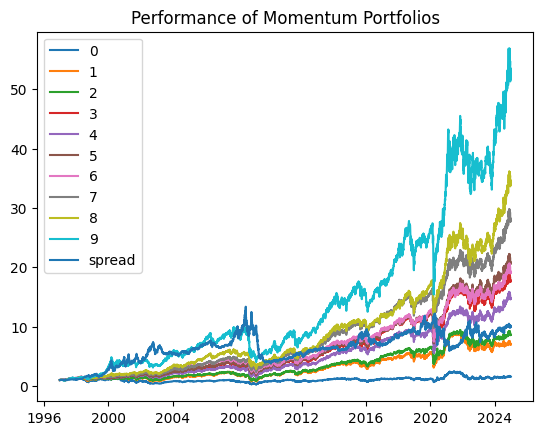

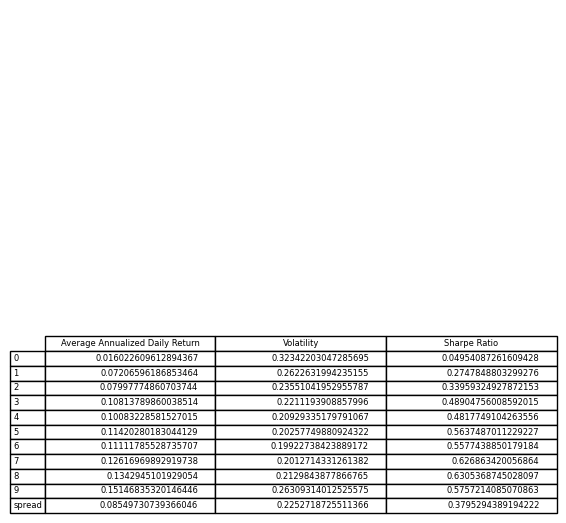

In [28]:
for portfolio in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'spread']:
    df = momentum_returns.filter(pl.col('bin') == portfolio)
    plt.plot(df.get_column("date"), df.get_column("cumulative_log_return").exp(), label=portfolio)
plt.title("Performance of Momentum Portfolios")
plt.legend()
plt.show()

portfolios = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'spread']
fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
results = []
for portfolio in portfolios:
    tempresults = []
    df = momentum_returns.filter(pl.col('bin') == portfolio)
    num_days = df.height
    tempresults.append((df.get_column("return")/100 + 1).product() ** (252/num_days) - 1)
    tempresults.append(((df.get_column("return")/100).std()*np.sqrt(252)))
    tempresults.append(tempresults[0]/tempresults[1])
    results.append(tempresults)

colLabels = ['Average Annualized Daily Return', 'Volatility', 'Sharpe Ratio']
table = ax.table(cellText = results, colLabels=colLabels, rowLabels=portfolios)
plt.subplots_adjust(left=0.1, bottom=0.2)
plt.show()

In [ ]:
# TODO: Create a table of summary metrics